In [2]:
import os, sys
import json
import h5py

import numpy as np
import scipy.stats as scipystats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from shutil import copyfile
from functools import reduce
from analysis.processing.utils import derive_session_type
from analysis.plots.utils import get_colors
from analysis.processing.epochs import get_epochs
from analysis.processing.theta import get_tpp, compute_and_save_tpp
from analysis.processing.metrics import get_field_match
from analysis.adapters.hdf5 import H5NAMES
from analysis.adapters.kwik import load_clu_res_single
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
report = '/home/andrey/storage2/andrey/data/projects/24_shift/theta'
theta_sampling = 1250

In [5]:
def get_sessions(source, animal):
    def is_dir(name):
        return os.path.isdir(os.path.join(source, animal, name))

    def has_h5(name):
        return os.path.exists(os.path.join(source, animal, name, '%s.h5' % H5NAMES.filebase))
    
    return [x for x in os.listdir(os.path.join(source, animal)) if is_dir(x) and has_h5(x)]

In [6]:
selected_sessions = [
    ('005364', '2020-10-09_16-02-59', '8_2'),  # something there
    ('005364', '2020-10-08_22-25-34', '8_10'), # no presession when dark?
    ('005364', '2020-10-11_12-36-05', '1_8'),  # good TPP, no change bw conditions
    ('003909', '2020-03-27_18-41-37', '2_11'), # kind of disappears A->B
    ('003909', '2020-03-27_18-41-37', '6_7'),  # nice A-B and Ad-Bd, phase shift in dark
    ('003282', '2019-11-21_21-58-48', '7_9'),  # ~nothing
    ('003282', '2019-11-24_20-06-11', '4_10'), # ~nothing
    ('003282', '2019-12-02_17-51-29', '5_10')  # low precession
]

# Phase preference

### single session

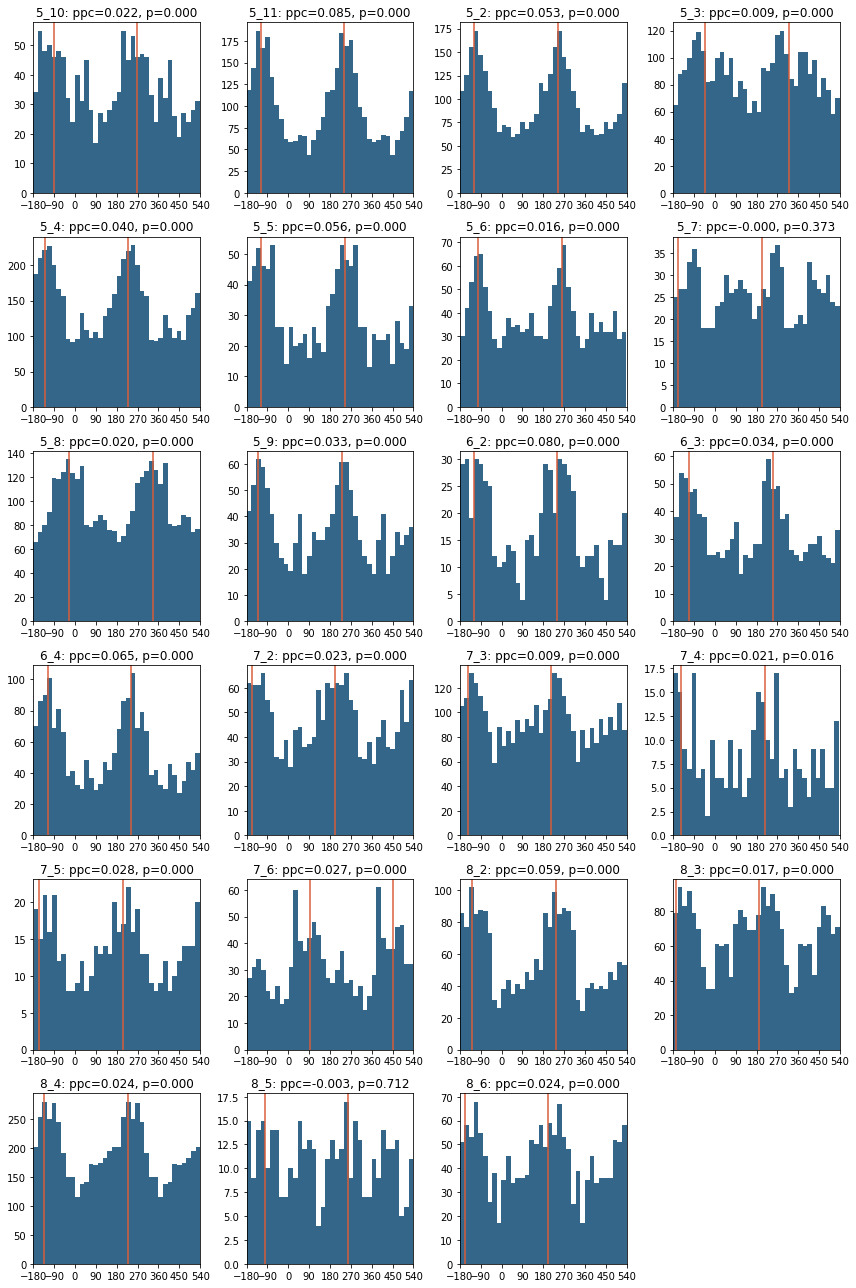

In [127]:
fpath = '/home/andrey/storage2/andrey/data/processed/005364/2020-10-12_12-48-04/all.h5'

with h5py.File(fpath, 'r') as f:
    unit_num = len(f['units'])

rows_num = int(unit_num/4) + 1
fig = plt.figure(figsize=(12, rows_num * 3))

with h5py.File(fpath, 'r') as f:
    for i, unit_group in enumerate(f['units']):
        running_idxs = np.array(f['running_idxs'])
        spike_idxs = np.array(f['units'][unit_group]['spike_idxs'])
        ds = f['units'][unit_group]['theta_mod']
        th_mod = np.array(ds)[np.isin(spike_idxs, running_idxs)]  # filter by running

        ppc = ds.attrs['ppc']
        th0 = ds.attrs['th0']
        p_v = ds.attrs['p']
        
        ax = fig.add_subplot(rows_num, 4, i + 1)
        ax.hist( (np.concatenate([th_mod, th_mod + 2*np.pi]) ) * 180/np.pi, 36, color=COLORS['a'])
        ax.axvline(( th0 ) * 180/np.pi, color=COLORS['b'])
        ax.axvline(( th0 + 2*np.pi ) * 180/np.pi, color=COLORS['b'])
        ax.set_title('%s: ppc=%.3f, p=%.3f' % (unit_group, ppc, p_v))
        ax.set_xlim(-180, 540)
        ax.set_xticks([-180 + 90*x for x in range(9)])

fig.tight_layout()

### diff conditions for a single cell 

In [163]:
session_path = os.path.join(source, '005364', '2020-10-12_12-48-04')
fpath = os.path.join(session_path, '%s.h5' % H5NAMES.filebase)
unit_name = '8_6'

phases = {}
th0 = {}
conditions = list(get_epochs(session_path).keys())
with h5py.File(fpath, 'r') as f:
    traj = np.array(f['animal_trajectory'])
    running_idxs = np.array(f['running_idxs'])
    spike_idxs = np.array(f['units'][unit_name]['spike_idxs'])
    theta_mod = np.array(f['units'][unit_name]['theta_mod'])

    for condition in conditions:
        if not condition in f['units'][unit_name]:
            continue
    
        cond_idxs = np.intersect1d(np.array(f['%s_idxs' % condition]), running_idxs)
        #down_idxs = np.where(traj[:, 2] < 0)[0]
        #cond_idxs = np.intersect1d(cond_idxs, down_idxs)
        cond_th = theta_mod[np.isin(spike_idxs, cond_idxs)]
        
        phases[condition] = cond_th
        #th0[condition] = f['units'][unit_name][condition].attrs['rayleigh_th0']

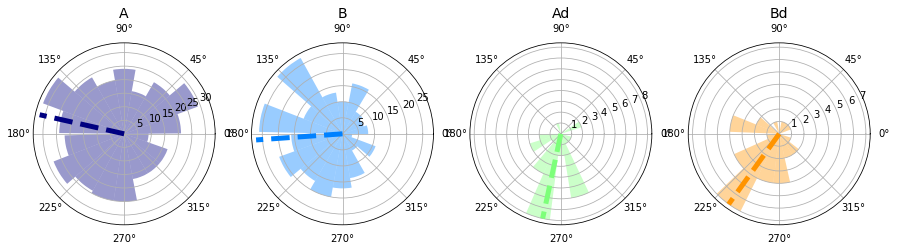

In [166]:
cond_num = len(phases)
colors = cm.jet( np.arange(cond_num)/cond_num )
patches = [mpatches.Patch(color=x, label=conditions[i]) for i, x in enumerate(colors)]

fig = plt.figure(figsize=(15, 6))

for i, cond in enumerate(conditions):
    ax = fig.add_subplot(1, cond_num, i + 1, projection='polar')
    cond_th = phases[cond].T[0]
    bin_vals = ax.hist(cond_th, 18, color=colors[i], alpha=0.4)
    #ax.scatter(data[:, 0], data[:, 2], color=colors, alpha=0.5)
    #ax.set_ylim(0, 0.6) 
    #ax.legend(handles=patches)
    ax.set_title("%s" % cond, fontsize=14)
    #ax.set_xlabel('Theta phase, deg', fontsize=14)

    #ids = np.unique(data[:, 3])
    th0_mean = scipystats.circmean(cond_th)
    #R_means =   [data[data[:, 3]==x][:, 2].mean() for x in ids]  # can't see
    #R_means =   [0.6 for x in ids]

    ax.vlines([th0_mean], [0], [bin_vals[0].max()], ls='--', lw=5.0, color=colors[i])

In [165]:
# '005364', '2020-10-12_12-48-04' '8_6' # turn off the light changes the preferred phase

### population / all animals

In [55]:
#fpath = '/home/andrey/storage2/andrey/data/processed/005364/2020-11-18_10-40-40/all.h5'

animals = ['00908', '00910', '002784', '003281', '003908', '003909', '005363', '005364']
animals = ['005364'] # ???
export = False


def get_sessions(source, animal):
    def is_dir(name):
        return os.path.isdir(os.path.join(source, animal, name))

    def has_h5(name):
        return os.path.exists(os.path.join(source, animal, name, '%s.h5' % H5NAMES.filebase))
    
    return [x for x in os.listdir(os.path.join(source, animal)) if is_dir(x) and has_h5(x)]
    
data = []
phase_hists = []
a_clr = 0  # unique color of the animal
s_clr = 0  # unique color of the session
for animal in animals:
    sessions = get_sessions(source, animal)
    a_clr += 1
    print("Processing %s.." % animal)
    for session in sessions:
        s_clr += 1
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        if not os.path.exists(h5path):
            continue
        with h5py.File(h5path, 'r') as f:
            running_idxs = np.array(f['running_idxs'])
            
            for i, unit_group in enumerate(f['units']):
                if not 'theta_mod' in f['units'][unit_group]:
                    continue

                th_mod = f['units'][unit_group]['theta_mod']
                th0 = float(th_mod.attrs['th0'])
                ppc = float(th_mod.attrs['ppc'])
                R = float(th_mod.attrs['r'])

                data.append([th0, ppc, R, a_clr, s_clr])

                # export phase histograms
                if not export:
                    continue
                        
                spike_idxs = np.array(f['units'][unit_group]['spike_idxs'])
                th_mod = np.array(f['units'][unit_group]['theta_mod'])[np.isin(spike_idxs, running_idxs)]  # filter

                hist, edges = np.histogram((np.concatenate([th_mod, th_mod + 2*np.pi]) ) * 180/np.pi, 36)
                
                phase_hists.append(hist)
        
data = np.array(data)
if export:
    ph_sh = pd.DataFrame(phase_hists, dtype=np.int32)
    ph_sh.to_csv(os.path.join(report, 'phase_shifts_all.csv'), index=False, header=False)

Processing 005364..


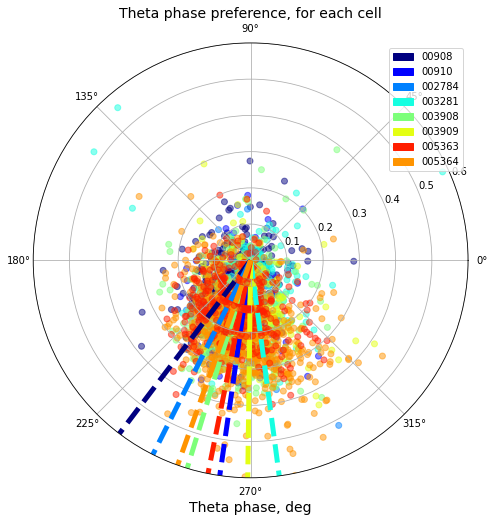

In [198]:
colors = cm.jet( (data[:, 3] - 1) / (data[:, 3].max()) )
patches = [mpatches.Patch(color=x, label=animals[i]) for i, x in enumerate(np.unique(colors, axis=0))]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.scatter(data[:, 0], data[:, 2], color=colors, alpha=0.5)
ax.set_ylim(0, 0.6) 
ax.legend(handles=patches)
ax.set_title("Theta phase preference, for each cell", fontsize=14)
ax.set_xlabel('Theta phase, deg', fontsize=14)

ids = np.unique(data[:, 3])
th0_means = [stats.circmean(data[data[:, 3]==x][:, 0]) for x in ids]
R_means =   [data[data[:, 3]==x][:, 2].mean() for x in ids]  # can't see
R_means =   [0.6 for x in ids]

ax.vlines(th0_means, np.zeros(len(ids)), R_means, ls='--', lw=5.0, colors=np.unique(colors, axis=0))

#filename = "theta_preference_003282.png"
#fig.savefig(os.path.join(os.path.join(report), filename))